# ICIAR 2018 Classification Challenge

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.dataset import *
from fastai.dataloader import *
from fastai.conv_learner import *
from fastai.plots import *

In [3]:
PATH = '/home/ubuntu/workspace/data/iciar18/full_dataset/'

## Look at some images

(1536, 2048, 3)


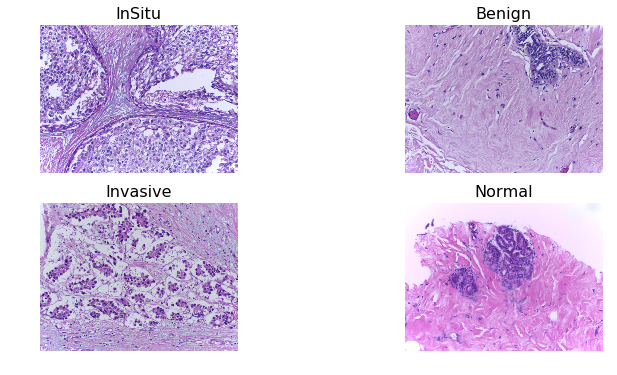

In [4]:
im_is = plt.imread(f'{PATH}is001.jpg')
im_b = plt.imread(f'{PATH}b001.jpg')
im_iv = plt.imread(f'{PATH}iv001.jpg')
im_n = plt.imread(f'{PATH}n001.jpg')
ims = np.stack([im_is, im_b, im_iv, im_n])
plots(ims, rows = 2, titles=['InSitu', 'Benign', 'Invasive', 'Normal'])
print(im_n.shape)
# plt.imshow(im); plt.show()

## Some useful functions

In [4]:
def get_val_idxs(n_per_class, val_pct, nclasses):
    v_idxs = get_cv_idxs(n_per_class, val_pct=val_pct, seed=24)
    v_next_idxs = [v_idxs + i*100 for i in range(1, nclasses)]
    v_idxs = [v_idxs] + v_next_idxs
    return np.concatenate(v_idxs)

In [5]:
def get_data(csv_fname, arch, sz, bs, val_idxs, aug=transforms_top_down):
    tfms = tfms_from_model(arch, sz, aug_tfms=aug, max_zoom=1.05)
    data = ImageClassifierData.from_csv(PATH, '', f'{PATH}{csv_fname}', bs,tfms,val_idxs)
    return data

In [68]:
def plot_cm(classes, y, preds):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, classes)
    
def evaluate(learner, aug=False):
    aug_logs = None
    log_preds,y = None, None
    if aug:
        aug_logs,y = learner.TTA()
        log_preds = np.mean(aug_logs, axis=0)
    else: 
        log_preds,y = learner.predict_with_targs()
    print(accuracy(log_preds,y))
    if aug:
        for l in aug_logs:
            print(accuracy(l,y))
    preds = np.argmax(log_preds, axis=1)
    plot_cm(learner.data.classes, y, preds)
    return log_preds, y

## Multiclass approach

Here we build a model to classify directly the 4 pathological groups.

## Experiment 1

In [11]:
arch=resnet50
bs=16
sz=299

A Jupyter Widget

[   0.         5.36809  924.12677    0.375  ]             



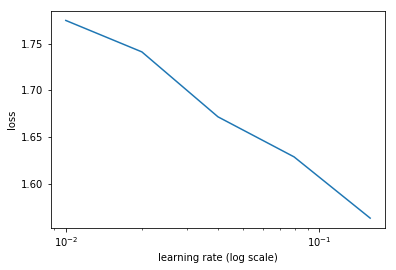

In [12]:
val_idxs = get_val_idxs(100, 0.2, 4)
data = get_data('train_multi.csv', arch, sz, bs, val_idxs)
learner = ConvLearner.pretrained(arch, data, precompute=False)
learner.lr_find()
learner.sched.plot()

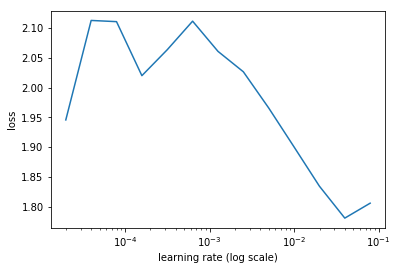

In [9]:
learner.sched.plot(1)

In [13]:

lrf = 0.01

In [42]:
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

  0%|          | 0/20 [00:00<?, ?it/s]                    


Exception in thread Thread-96:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.28652  1.1112   0.475  ]                     
[ 1.       1.04167  0.87787  0.5875 ]                     
[ 2.       0.89019  0.87585  0.6    ]                      



In [43]:
learner.unfreeze()
lr = np.array([lrf/25., lrf/5., lrf])
learner.fit(lr, 3, cycle_len=2, cycle_mult=2)

A Jupyter Widget

[ 0.       1.03214  0.92917  0.6625 ]                     
[ 1.       0.83724  0.83023  0.675  ]                      
[ 2.       0.76866  1.07715  0.675  ]                      
[ 3.       0.67543  0.50995  0.8125 ]                      
[ 4.       0.5443   0.52189  0.7875 ]                      
[ 5.       0.42673  0.48632  0.775  ]                      
[ 6.       0.36175  0.3656   0.8875 ]                      
[ 7.       0.32849  0.70743  0.775  ]                      
[ 8.       0.28597  0.70876  0.7625 ]                      
[ 9.       0.24942  0.58888  0.8    ]                      
[ 10.        0.22322   0.32012   0.8625 ]                  
[ 11.        0.18285   0.29042   0.8625 ]                  
[ 12.        0.16069   0.26319   0.8875 ]                  
[ 13.        0.13346   0.2745    0.875  ]                  



In [44]:
learner.save('multi_299_87')

In [26]:
learner.load('multi_299_87')

0.9125                                       
[[19  0  1  0]
 [ 1 17  2  0]
 [ 0  1 18  1]
 [ 1  0  0 19]]


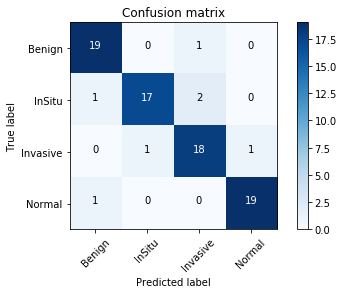

In [50]:
log_augs, y = evaluate(learner, aug=True)

In [51]:
len(log_augs)
for l in log_augs: print(accuracy(l,y))

0.875
0.925
0.9
0.9125
0.85


## Resume experiment 1

0.9375                                       
[[19  1  0  0]
 [ 0 18  2  0]
 [ 0  1 19  0]
 [ 1  0  0 19]]


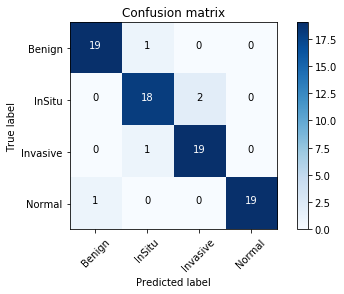

In [14]:
val_idxs = get_val_idxs(100, 0.2, 4)
data = get_data('train_multi.csv', arch, sz, bs, val_idxs)
learner = ConvLearner.pretrained(arch, data, precompute=False)
learner.unfreeze()
learner.load('multi_299_87')
log_augs, y = evaluate(learner, aug=True)

In [15]:
len(log_augs)
for l in log_augs: print(accuracy(l,y))

0.875
0.925
0.9125
0.9375
0.8875


In [24]:
learner.load('multi_299_87')
new_sz = int(sz*1.2)
learner.set_data(get_data('train_multi.csv', arch, new_sz, bs, val_idxs))

In [25]:
learner.unfreeze()
lr = np.array([lrf/18., lrf/5., lrf])
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.10373  0.45621  0.8625 ]                       
[ 1.       0.14135  0.72551  0.7875 ]                      
[ 2.       0.15416  0.47873  0.85   ]                      
[ 3.       0.17397  0.4558   0.8    ]                      
[ 4.       0.16325  0.50877  0.7875 ]                      
[ 5.       0.12465  0.56419  0.8125 ]                      
[ 6.       0.12279  0.60639  0.8    ]                      



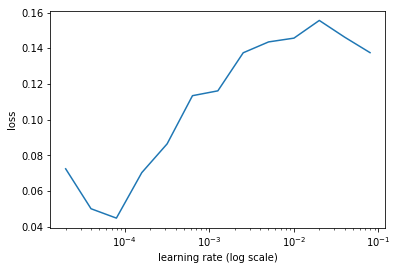

In [20]:
learner.sched.plot(1)

## Experiment 2: increase dropout to combat overfitting

In [9]:
arch=resnet50
bs=16
sz=299

A Jupyter Widget

 95%|█████████▌| 19/20 [00:13<00:00,  1.43it/s, loss=8.84]

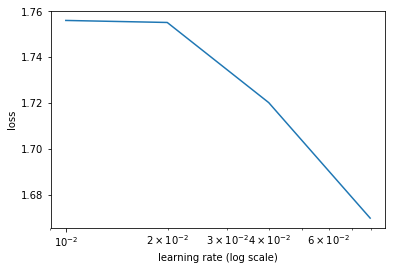

In [65]:
val_idxs = get_val_idxs(100, 0.2, 4)
aug = [RandomRotateXY(10), RandomDihedralXY(), RandomFlipXY()]
data = get_data('train_multi.csv', arch, sz, bs, val_idxs, aug=aug)
learner = ConvLearner.pretrained(arch, data, ps=0.6, precompute=False)
learner.lr_find()
learner.sched.plot()

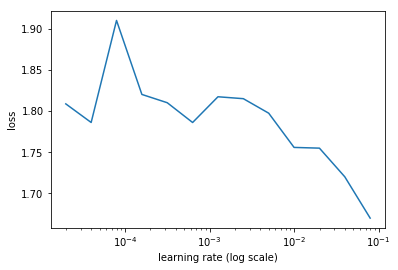

In [66]:
learner.sched.plot(1)

In [67]:
lrf = 0.03

In [68]:
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

  5%|▌         | 1/20 [00:04<01:26,  4.54s/it, loss=1.77]

Exception in thread Thread-92:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.54933  1.32451  0.525  ]                     
[ 1.       1.42496  1.51523  0.5    ]                     
[ 2.       1.38981  1.35038  0.5375 ]                     



In [69]:
learner.unfreeze()
lr = np.array([lrf/25., lrf/5., lrf])
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       2.26087  3.10187  0.4875 ]                     
[ 1.       2.14359  1.74839  0.5    ]                     
[ 2.       1.82788  1.03256  0.6125 ]                     
[ 3.       1.69582  1.97146  0.6125 ]                     
[ 4.       1.73598  1.52629  0.5125 ]                     
[ 5.       1.64901  0.74838  0.75   ]                     
[ 6.       1.45563  0.70387  0.75   ]                     



In [70]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       1.28958  0.95471  0.775  ]                     
[ 1.       1.20379  1.02149  0.675  ]                     
[ 2.       1.10809  0.74545  0.7375 ]                     
[ 3.       1.29808  1.15641  0.675  ]                     
[ 4.       1.24901  0.94317  0.7    ]                     
[ 5.       1.19761  0.61317  0.75   ]                     
[ 6.       1.08937  0.58642  0.75   ]                     



In [71]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.85666  0.7597   0.75   ]                      
[ 1.       0.80404  1.11083  0.6    ]                      
[ 2.       0.8378   0.74396  0.7375 ]                      
[ 3.       0.83555  0.63215  0.825  ]                      
[ 4.       0.81387  0.8116   0.6875 ]                      
[ 5.       0.78255  0.8362   0.7375 ]                      
[ 6.       0.64959  0.75417  0.8125 ]                      



In [72]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.54602  0.61131  0.775  ]                      
[ 1.       0.72767  0.7625   0.7375 ]                      
[ 2.       0.65939  0.54752  0.775  ]                      
[ 3.       0.61656  0.58861  0.8    ]                      
[ 4.       0.61054  1.14137  0.675  ]                      
[ 5.       0.54651  0.58146  0.8    ]                      
[ 6.       0.47033  0.45591  0.8375 ]                      



In [73]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.32131  0.476    0.8375 ]                      
[ 1.       0.44647  0.52373  0.825  ]                      
[ 2.       0.36129  0.35561  0.825  ]                      
[ 3.      0.3973  0.4593  0.825 ]                          
[ 4.       0.35835  0.567    0.8    ]                      
[ 5.       0.32578  0.39794  0.8375 ]                      
[ 6.       0.27532  0.34834  0.825  ]                      



In [74]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=3)

A Jupyter Widget

[ 0.       0.20156  0.31803  0.825  ]                      
[ 1.       0.22314  0.65447  0.7625 ]                      
[ 2.       0.29417  0.6407   0.8    ]                      
[ 3.       0.25977  0.4727   0.8375 ]                      
[ 4.       0.29571  0.78383  0.8    ]                      
[ 5.       0.39991  0.51412  0.875  ]                      
[ 6.       0.43372  0.38345  0.875  ]                      
[ 7.       0.45569  0.54427  0.8    ]                      
[ 8.       0.41347  0.40329  0.85   ]                      
[ 9.       0.38022  0.46405  0.8375 ]                      
[ 10.        0.31827   0.33704   0.8625 ]                  
[ 11.        0.27922   0.28822   0.9    ]                  
[ 12.        0.2397    0.28841   0.9    ]                  



In [75]:
learner.save('multi_exp2_ps.6_90')

In [ ]:
learner.load('multi_exp2_ps.6_90')

0.9                                          
[[17  2  0  1]
 [ 2 16  2  0]
 [ 1  0 19  0]
 [ 0  0  0 20]]
0.9
0.8625
0.875
0.825
0.8625


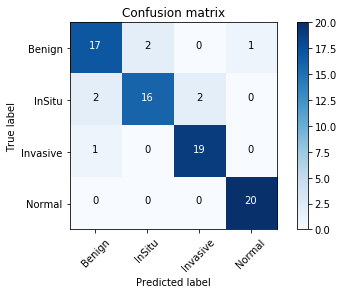

In [76]:
log_ags, y = evaluate(learner, True)
for l in log_ags: print(accuracy(l,y))

In [77]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.17913  0.30607  0.875  ]                      
[ 1.       0.18182  0.55664  0.8625 ]                      
[ 2.       0.20948  0.44823  0.875  ]                      
[ 3.       0.27677  0.33783  0.85   ]                      
[ 4.       0.3119   0.32218  0.8625 ]                      
[ 5.       0.27039  0.33124  0.875  ]                      
[ 6.       0.21883  0.29541  0.8875 ]                      



In [78]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.16203  0.25198  0.9    ]                      
[ 1.       0.18249  0.30312  0.9125 ]                      
[ 2.       0.15486  0.27849  0.9    ]                      
[ 3.       0.17687  0.35457  0.8625 ]                      
[ 4.       0.16596  0.33163  0.8875 ]                      
[ 5.       0.14828  0.33106  0.9125 ]                      
[ 6.       0.13111  0.33015  0.9    ]                      



0.9                                          
[[17  2  0  1]
 [ 2 17  1  0]
 [ 2  0 18  0]
 [ 0  0  0 20]]
0.9
0.875
0.8875
0.9125
0.8625


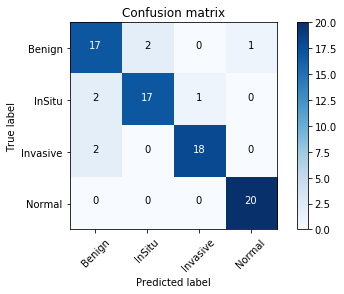

In [81]:
log_ags, y = evaluate(learner, True)
for l in log_ags: print(accuracy(l,y))

In [82]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.30284  0.39722  0.9    ]                      
[ 1.       0.1922   0.34253  0.8875 ]                      
[ 2.       0.16835  0.33839  0.8875 ]                      
[ 3.       0.1954   0.30813  0.9125 ]                      
[ 4.       0.16639  0.35172  0.875  ]                      
[ 5.       0.18484  0.2234   0.875  ]                      
[ 6.       0.1785   0.19793  0.9125 ]                      



0.8875                                       
[[16  3  0  1]
 [ 2 15  3  0]
 [ 0  0 20  0]
 [ 0  0  0 20]]
0.9125
0.875
0.8625
0.875
0.875


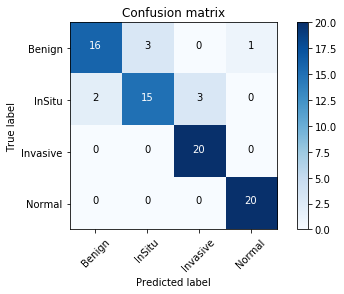

In [85]:
log_ags, y = evaluate(learner, True)
for l in log_ags: print(accuracy(l,y))

In [86]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09353  0.3051   0.9125 ]                       
[ 1.       0.14614  0.27782  0.9    ]                       
[ 2.       0.14443  0.27108  0.9    ]                      
[ 3.       0.13407  0.45124  0.8625 ]                      
[ 4.       0.1552   0.37399  0.875  ]                      
[ 5.       0.15674  0.29309  0.9125 ]                      
[ 6.       0.14578  0.26982  0.95   ]                      



In [87]:
learner.save('multi_exp2_ps.6_95')

In [10]:
val_idxs = get_val_idxs(100, 0.2, 4)
aug = [RandomRotateXY(10), RandomDihedralXY(), RandomFlipXY()]
data = get_data('train_multi.csv', arch, sz, bs, val_idxs, aug=aug)
learner = ConvLearner.pretrained(arch, data, ps=0.6, precompute=False)
learner.unfreeze()
learner.load('multi_exp2_ps.6_95')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:07<00:00, 14020477.66it/s]


0.95
[[18  1  0  1]
 [ 1 18  1  0]
 [ 0  0 20  0]
 [ 0  0  0 20]]


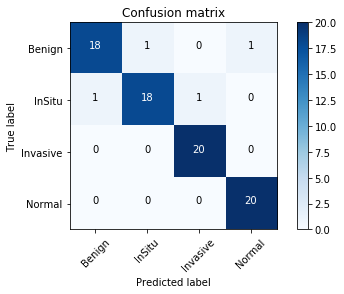

In [11]:
log_ags, y = evaluate(learner)
# for l in log_ags: print(accuracy(l,y))

In [12]:
lrf=0.03
lr = np.array([lrf/25., lrf/5., lrf])
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.15602  0.26883  0.9125 ]                       
[ 1.       0.16256  0.48939  0.8875 ]                      
[ 2.       0.12805  0.38559  0.9    ]                      
[ 3.       0.12687  0.43387  0.9125 ]                      
[ 4.       0.1425   0.44146  0.8875 ]                      
[ 5.       0.13757  0.2537   0.9    ]                      
[ 6.       0.14222  0.24609  0.9    ]                      



In [13]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.19458  0.30167  0.9    ]                      
[ 1.       0.11822  0.40362  0.875  ]                      
[ 2.       0.11671  0.19293  0.925  ]                       
[ 3.       0.11201  0.28813  0.9125 ]                       
[ 4.       0.13233  0.23673  0.9    ]                      
[ 5.       0.11883  0.2251   0.9125 ]                      
[ 6.       0.10864  0.23001  0.9125 ]                      



In [14]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.06877  0.19835  0.9125 ]                       
[ 1.       0.08106  0.25829  0.9125 ]                       
[ 2.       0.07946  0.23422  0.925  ]                       
[ 3.       0.08266  0.38416  0.85   ]                       
[ 4.       0.09729  0.14761  0.925  ]                       
[ 5.       0.08728  0.20269  0.9125 ]                       
[ 6.       0.0764   0.19478  0.925  ]                       



0.9375                                       
0.925
0.9
0.925
0.9
0.8875
[[17  2  0  1]
 [ 1 18  0  1]
 [ 0  0 20  0]
 [ 0  0  0 20]]


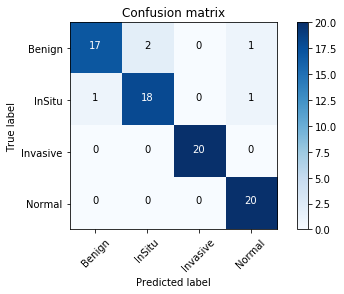

In [16]:
a = evaluate(learner,True)

In [119]:
top_layers = list(learner.children)[8:]
top_layers =  [AdaptiveConcatPool2d(), Flatten(), 
            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True), 
            nn.Dropout(p = 0.6), nn.Linear(4096,512), nn.ReLU(), 
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True), 
            nn.Dropout(p = 0.6), 
            nn.Linear(512,4), 
            nn.LogSoftmax()]

In [123]:
# m = resnet50()
AdaptiveConcatPool2d

fastai.layers.AdaptiveConcatPool2d

In [120]:
m1 = nn.Sequential(*list(m.children())[:-2])
layerss = [AdaptiveConcatPool2d(), Flatten()]
# m1
# m1.add_module('8', nn.Sequential(*layerss))
# m1.add_module('9', nn.Sequential(*top_layers) )

In [121]:
for k, l in enumerate(top_layers):
    m1.add_module(str(7+k+1), l)

In [122]:
m1

Sequential (
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU (inplace)
  (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bottleneck (
      (

In [91]:
list(m1.modules())[-11:]

[AdaptiveAvgPool2d (output_size=(1, 1)),
 AdaptiveMaxPool2d (output_size=(1, 1)),
 Flatten (
 ),
 BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True),
 Dropout (p = 0.6),
 Linear (4096 -> 512),
 ReLU (),
 BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
 Dropout (p = 0.6),
 Linear (512 -> 4),
 LogSoftmax ()]

In [54]:
load_model(m1, f'{PATH}models/multi_exp2_ps.6_95.h5')

KeyError: 'unexpected key "10.weight" in state_dict'

In [23]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2, cycle_save_name='multi_exp2_80+')

A Jupyter Widget

[ 0.       0.32786  0.40735  0.85   ]                      
[ 1.       0.28632  0.4615   0.7875 ]                      
[ 2.       0.25883  0.37209  0.8625 ]                      
[ 3.       0.25969  0.38269  0.8125 ]                      
[ 4.       0.29087  0.53362  0.775  ]                      
[ 5.       0.24887  0.28253  0.9    ]                      
[ 6.       0.20923  0.2594   0.8875 ]                      



In [28]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2, cycle_save_name='multi_exp2_80+')

A Jupyter Widget

[ 0.       0.16655  0.30662  0.85   ]                      
[ 1.       0.20448  0.22696  0.9    ]                      
[ 2.       0.16902  0.2579   0.9    ]                      
[ 3.       0.15428  0.25727  0.9125 ]                      
[ 4.       0.16188  0.49803  0.8375 ]                      
[ 5.       0.13146  0.30672  0.875  ]                      
[ 6.       0.11526  0.31012  0.875  ]                      



In [49]:
learner.load('multi_exp2_91')

In [50]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2, cycle_save_name='multi_exp2_80+')

A Jupyter Widget

[ 0.       0.19113  0.3868   0.875  ]                      
[ 1.       0.16473  0.44505  0.875  ]                      
[ 2.       0.15916  0.39673  0.8375 ]                      
[ 3.       0.20195  0.61347  0.8125 ]                      
[ 4.       0.17757  0.48945  0.825  ]                      
[ 5.       0.15887  0.36253  0.825  ]                      
[ 6.       0.14153  0.36222  0.8625 ]                      



In [51]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2, cycle_save_name='multi_exp2_80+')

A Jupyter Widget

[ 0.       0.10968  0.36753  0.8375 ]                      
[ 1.       0.1093   0.24527  0.925  ]                      
[ 2.       0.12612  0.28313  0.9    ]                       
[ 3.       0.09004  0.29267  0.9    ]                       
[ 4.       0.07282  0.36956  0.8625 ]                       
[ 5.       0.0847   0.31308  0.8625 ]                       
[ 6.       0.07908  0.27932  0.8875 ]                       



In [62]:
learner.load_cycle('multi_exp2_80+', 1)

0.85                                         
[[15  3  2  0]
 [ 1 16  3  0]
 [ 1  1 17  1]
 [ 0  0  0 20]]


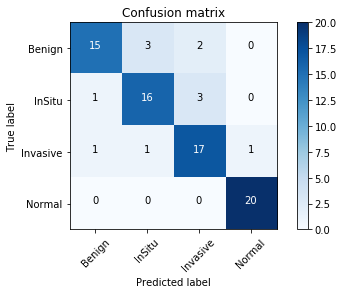

In [63]:
log_ags, y = evaluate(learner, True)

In [61]:
for l in log_ags: print(accuracy(l,y))

0.8875
0.8625
0.85
0.85
0.8875


In [16]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2, cycle_save_name='exp2_80+')

A Jupyter Widget

[ 0.       0.12299  0.35231  0.8875 ]                      
[ 1.       0.15065  0.41812  0.8375 ]                      
[ 2.       0.1461   0.41177  0.825  ]                      
[ 3.      0.1442  0.7052  0.85  ]                          
[ 4.       0.14563  0.3377   0.8625 ]                      
[ 5.       0.14492  0.26943  0.8625 ]                      
[ 6.       0.12825  0.30932  0.85   ]                      



In [28]:
learner.save('multi_exp2_224_86')

In [ ]:
learner.load('multi_exp2_224_86')

0.9                                          
[[19  1  0  0]
 [ 1 16  3  0]
 [ 1  1 18  0]
 [ 0  1  0 19]]


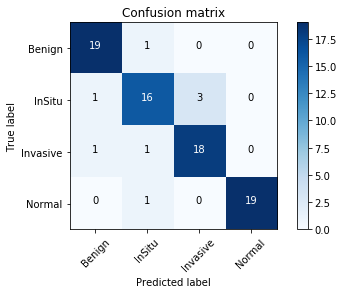

In [29]:
log_augs, y = evaluate(learner, True)

In [30]:
for l in log_augs: print(accuracy(l,y))

0.8625
0.8
0.9125
0.8875
0.85


In [31]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.1568   0.53567  0.775  ]                      
[ 1.       0.20616  0.64359  0.75   ]                      
[ 2.       0.20502  0.67565  0.75   ]                      
[ 3.       0.21486  0.82186  0.825  ]                      
[ 4.       0.24467  0.66897  0.8    ]                      
[ 5.       0.21455  0.51839  0.8375 ]                      
[ 6.       0.20599  0.46258  0.8625 ]                      



In [32]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=3)

A Jupyter Widget

[ 0.       0.17038  0.31407  0.8625 ]                       
[ 1.       0.13526  0.48745  0.825  ]                      
[ 2.       0.21743  0.45299  0.8125 ]                      
[ 3.       0.19666  0.50478  0.8125 ]                      
[ 4.       0.16335  0.41892  0.8125 ]                      
[ 5.       0.15421  0.40323  0.85   ]                      
[ 6.       0.13771  0.48677  0.8125 ]                      
[ 7.       0.16114  0.37541  0.85   ]                      
[ 8.       0.16081  0.57004  0.775  ]                      
[ 9.       0.15373  0.53144  0.825  ]                      
[ 10.        0.13911   0.38455   0.8625 ]                  
[ 11.        0.10856   0.32962   0.85   ]                  
[ 12.        0.09935   0.35001   0.85   ]                   



In [64]:
type(learner.model)

torch.nn.modules.container.Sequential

## Prepare executable

In [67]:
import pickle as pk

name = 'multi_exp2_ps.6_95'
learner.load('multi_exp2_ps.6_95')

# copy model object
file = open(f'{PATH}models/{name}_model.pk', 'wb') 
pk.dump(learner.model, file)
# learner.model.__reduce__()

KeyboardInterrupt: 

In [37]:

#learner = Learner.load('multi_299_87')
fn = f'{PATH}Photos/Invasive/iv011.tif'
trn_tfms, val_tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05) # get transformations
im = open_image(fn)
im_val = val_tfms(im)

In [38]:
im_val.shape

(3, 299, 299)

In [39]:
model = torchvision.models.resnet50()
model.load_state_dict(torch.load(f'{PATH}/models/multi_299_87.h5'))
model.type(torch.cuda.FloatTensor)
model.eval()
x = torch.from_numpy(im_val).type(torch.cuda.FloatTensor)
# x = x.permute(0,3,1,2)
print(x.size())
log_pred = model(Variable(x).unsqueeze(0))
log_pred

KeyError: 'unexpected key "0.weight" in state_dict'

In [ ]:
pred = np.argmax(log_preds)

In [35]:
preds = learner.predict_array(im_val[None])
pred = np.argmax(preds)
devt_classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
submit_classes = {'Normal':0, 'Benign':1, 'InSitu':2, 'Invasive':3}
f'class prediction: {submit_classes[devt_classes[pred]]} => {devt_classes[pred]}'

'class prediction: 2 => InSitu'

In [26]:
learner.data.classes

['Benign', 'InSitu', 'Invasive', 'Normal']

In [28]:
devt_classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
submit_classes = {'Normal':0, 'Benign':1, 'InSitu':2, 'Invasive':3}
f'class prediction: {submit_classes[classes[pred]]} => {classes[pred]}'

'class predction: 2 => InSitu'

In [11]:
im_b = [cv2.cvtColor(cv2.imread(f'{PATH}b0{i}.jpg'), cv2.COLOR_BGR2RGB) for i in (np.random.randint(10, high=100,size=10))]
len(im_b)
im_b = np.array(im_b)
len(im_b)

10

In [12]:
model = learner.model
val_tf


In [13]:
import torchvision.transforms as T
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = T.Compose([normalize])

In [16]:
model.type(torch.cuda.FloatTensor)
model.eval()
x = torch.from_numpy(im_b).type(torch.cuda.FloatTensor)
x = preprocess(x)
x = x.permute(0,3,1,2)
print(x.size())

torch.Size([10, 3, 1536, 2048])


In [20]:
x[0].size()

torch.Size([3, 1536, 2048])

In [18]:

log_pred = model(Variable(x[0]).unsqueeze(0))
log_pred

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1503965122592/work/torch/lib/THC/generic/THCStorage.cu:66

In [100]:
pred = np.argmax(log_pred.data.cpu().numpy())
pred

3

In [101]:
classes = learner.data.classes
submit_classes = {'Normal':0, 'Benign':1, 'InSitu':2, 'Invasive':3}
submit_classes[classes[pred]], classes[pred]

(0, 'Normal')

## Experiment 2

In [16]:
arch=resnet50
bs=16
sz=299

A Jupyter Widget

 95%|█████████▌| 19/20 [00:12<00:00,  1.49it/s, loss=19.5]

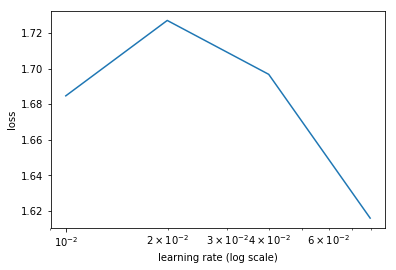

In [22]:
val_idxs = get_val_idxs(100, 0.2, 4)
data = get_data('train_multi.csv', arch, sz, bs, val_idxs)
learner = ConvLearner.pretrained(arch, data, precompute=False, opt_fn=optim.Adam)
learner.lr_find()
learner.sched.plot()


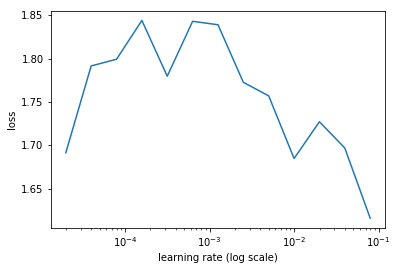

In [24]:
learner.sched.plot(1)

In [25]:
lrf = 0.03

In [26]:
learner.fit(lrf, 3, cycle_len=1, wds=0.03, use_wd_sched=True)

A Jupyter Widget

 40%|████      | 8/20 [00:06<00:09,  1.25it/s, loss=1.69] 


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.37124  1.25978  0.375  ]                     
[ 1.       1.08299  1.17039  0.55   ]                     
[ 2.       0.98032  1.14395  0.625  ]                      



In [27]:

wd = 0.025
learner.unfreeze()
learner.fit(lrs=[lrf/100, lrf/10,lrf], n_cycle=3, wds=[wd/100, wd/10, wd], use_wd_sched=True, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       1.34394  1.2922   0.425  ]                     
[ 1.       1.27622  1.32861  0.45   ]                     
[ 2.       1.19836  1.25884  0.4625 ]                     
[ 3.       1.16072  1.11991  0.525  ]                     
[ 4.       1.11665  1.01977  0.55   ]                     
[ 5.       1.06827  1.09091  0.5125 ]                     
[ 6.       1.02421  1.25399  0.5    ]                     



In [13]:
learner.fit(lrf, 3, cycle_len=1) # x 3

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.29882  0.92282  0.6375 ]                      
[ 1.       1.08655  0.8051   0.725  ]                      
[ 2.      1.0038  0.7873  0.7   ]                          



In [14]:
learner.fit(lrf, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.64655  0.76916  0.825  ]                       
[ 1.       0.62009  0.80696  0.8    ]                       
[ 2.       0.54398  0.65302  0.7875 ]                       
[ 3.       0.49294  0.60571  0.8    ]                       
[ 4.       0.46585  0.65984  0.8125 ]                       
[ 5.       0.39881  0.73402  0.825  ]                       
[ 6.       0.35467  0.71835  0.8375 ]                       



In [19]:
learner.save('16_256_precom')

In [ ]:
learner.load('16_256_precom')

In [20]:
learner.unfreeze()
len(learner.get_layer_groups())

3

In [31]:
learner.get_layer_groups()[0][2].trainable


False

In [32]:
learner.fit(lrf, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.95683  0.79059  0.8375 ]                      
[ 1.       1.01866  0.79618  0.8    ]                      
[ 2.       1.04345  0.76346  0.7875 ]                     



In [33]:
learner.precompute

False

In [34]:
learner.fit(lrf, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.98253  0.7299   0.8125 ]                      
[ 1.       0.901    0.79573  0.775  ]                      
[ 2.       0.85488  0.81733  0.775  ]                      



In [35]:
learner.fit(lrf, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.93639  0.86439  0.775  ]                      
[ 1.       0.94968  0.68749  0.8    ]                      
[ 2.       0.78126  0.64076  0.775  ]                      
[ 3.       0.73353  0.78834  0.775  ]                      
[ 4.       0.8097   0.73166  0.825  ]                      
[ 5.       0.79229  0.72255  0.825  ]                      
[ 6.       0.73105  0.70289  0.85   ]                      



In [36]:
learner.save('16_256_noprecom_last')

In [ ]:
learner.load('16_256_noprecom_last')

In [38]:
learner.fit(lrf, 3, cycle_len=1, cycle_mult=2) # x2

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.58429  0.65454  0.825  ]                      
[ 1.       0.58443  0.59232  0.85   ]                      
[ 2.       0.57356  0.60424  0.825  ]                      
[ 3.       0.60007  0.67547  0.775  ]                      
[ 4.       0.60062  0.62356  0.8125 ]                      
[ 5.       0.57933  0.59947  0.8375 ]                      
[ 6.       0.56479  0.58268  0.8375 ]                      



0.8375                                       
[[17  2  1  0]
 [ 1 16  1  2]
 [ 2  1 17  0]
 [ 1  2  0 17]]


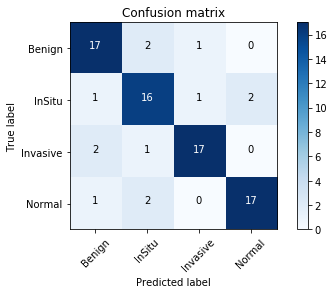

In [61]:
 log_preds,y = learner.TTA(n_aug=8)
# log_m = np.mean(log_preds, axis=0)
# prob_m = np.exp(log_m)
# prob_m[0]
log_m = log_preds[0]
y.shape, log_m.shape
print(accuracy(log_m,y))
preds = np.argmax(log_m, axis=1)
# probs = np.exp(log_preds[:,1])
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [9]:
def resize_data(arch, sz, bs):
    data_aug = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms = data_aug)
    return data

new_sz = 256
learner.set_data(resize_data(arch, new_sz, bs))

In [15]:
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.81459  0.71879  0.7375 ]                      
[ 1.       0.84532  0.54848  0.7375 ]                      
[ 2.       0.82659  0.56402  0.8    ]                      



In [16]:
learner.fit(lrf, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.72328  0.54024  0.825  ]                      
[ 1.       0.70947  0.54022  0.8    ]                      
[ 2.       0.69921  0.55939  0.8    ]                      
[ 3.       0.69425  0.59915  0.7625 ]                      
[ 4.       0.67761  0.6098   0.7875 ]                      
[ 5.       0.67032  0.58641  0.75   ]                      
[ 6.       0.62754  0.54288  0.7875 ]                      



In [18]:
learner.fit(lrf, 1, cycle_len=1, cycle_mult=1)

A Jupyter Widget

[ 0.       0.60853  0.54343  0.8375 ]                      



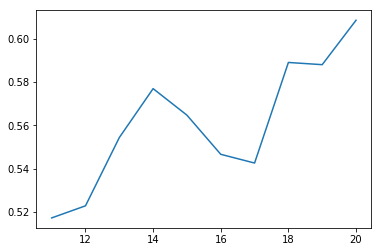

In [19]:
learner.sched.plot_loss()

In [8]:
new_sz = 524
learner.set_data(resize_data(arch, new_sz, bs))
# learner.fit(lrf, 2, cycle_len=1)

NameError: name 'resize_data' is not defined

In [21]:
learner.fit(lrf, 2, cycle_len=1, cycle_mult=2)# 1: 2 mult 2 , 2: 3 mult 2

A Jupyter Widget

[ 0.       0.77225  0.52718  0.8125 ]                      
[ 1.       0.72552  0.44394  0.875  ]                      
[ 2.       0.66467  0.42917  0.8625 ]                      



In [22]:
learner.fit(lrf, 2, cycle_len=1, cycle_mult=2)# 

A Jupyter Widget

[ 0.       0.69928  0.45054  0.825  ]                      
[ 1.       0.59445  0.37276  0.925  ]                      
[ 2.       0.57666  0.36566  0.9    ]                      



In [14]:
learner.unfreeze()
learner.load('resize128to524')

In [21]:
new_sz = 724
learner.set_data(resize_data(arch, new_sz, bs))
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.36349  0.44149  0.8    ]                      
[ 1.       0.367    0.42399  0.85   ]                      
[ 2.       0.32162  0.40477  0.8625 ]                      
[ 3.       0.32644  0.42762  0.8375 ]                      
[ 4.       0.32177  0.39391  0.85   ]                      
[ 5.       0.3373   0.39897  0.8625 ]                      
[ 6.       0.31214  0.39307  0.8625 ]                      



In [19]:
lr = np.array([lrf/4., lrf/2., lrf])

In [20]:
learner.fit(lrf, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.33924  0.59865  0.7875 ]                      
[ 1.       0.39858  0.5915   0.8375 ]                      
[ 2.       0.34221  0.58125  0.825  ]                      
[ 3.       0.37657  0.51576  0.8625 ]                      
[ 4.       0.38816  0.51552  0.8625 ]                      
[ 5.       0.38056  0.56581  0.85   ]                      
[ 6.       0.36204  0.57594  0.85   ]                      
[ 7.       0.36184  0.59639  0.8125 ]                      
[ 8.       0.34186  0.59006  0.7875 ]                      
[ 9.       0.31924  0.61434  0.7875 ]                      
[ 10.        0.33799   0.51901   0.8    ]                  
[ 11.        0.35587   0.5857    0.8125 ]                  
[ 12.        0.33868   0.53591   0.8125 ]                  
[ 13.        0.32499   0.51443   0.8125 ]                  
[ 14.        0.32859   0.48316   0.8125 ]                  



In [ ]:
l

### Increase the size of the image after training with a lower size
It helps fighting overfitting.
No paper published on that, good research direction.

In [15]:
def resize_data(arch, sz, bs):
    data_aug = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms = data_aug)
    return data

new_sz = 524
learner.set_data(resize_data(arch, new_sz, bs))
    

In [21]:
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.63612  0.57006  0.775  ]                      
[ 1.       0.62286  0.51205  0.8125 ]                      
[ 2.       0.65837  0.48818  0.75   ]                      



In [22]:
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.61001  0.48466  0.775  ]                      
[ 1.       0.60758  0.43452  0.8125 ]                      
[ 2.       0.549    0.40358  0.8375 ]                      



In [23]:
learner.fit(lrf, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.      0.6166  0.3946  0.8625]                          
[ 1.       0.55061  0.41585  0.8125 ]                      
[ 2.       0.53833  0.42129  0.825  ]                      



### Unfreeze all layers - Set earlier layers to 3x-10x lower learning rate than next higher layer

In [26]:
learner.load('resize64to524')
print(learner.data.sz)
learner.unfreeze()
lr = np.array([1e-2/9, 1e-2/3, 1e-2])

524


### Train full network with cycle_mult=2 until over-fitting

In [27]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       1.07439  0.71897  0.7375 ]                     
[ 1.       0.89325  0.60672  0.8625 ]                      
[ 2.       0.71364  0.46977  0.85   ]                      
[ 3.       0.6468   0.51651  0.8625 ]                      
[ 4.       0.55808  0.42911  0.8375 ]                      
[ 5.       0.48925  0.27636  0.9    ]                      
[ 6.       0.43526  0.33988  0.8875 ]                      



In [28]:
learner.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.35741  0.40836  0.8875 ]                      
[ 1.       0.3095   0.37791  0.9    ]                      



In [29]:
learner.save('resize64to524_all')

In [18]:
learner.fit(lr, 2, cycle_len=1, cycle_mult=2)


A Jupyter Widget

[ 0.       0.33438  0.41153  0.8875 ]                      
[ 1.       0.35693  0.40036  0.8875 ]                      
[ 2.       0.34405  0.39143  0.8875 ]                      



A Jupyter Widget

 95%|█████████▌| 19/20 [00:00<00:00, 61.25it/s, loss=9.7] 


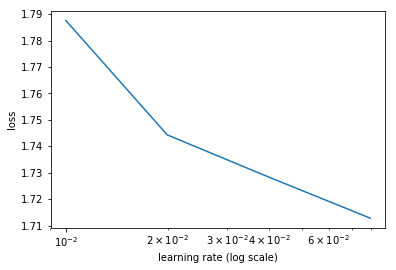

In [17]:
sz = 500
arch=resnet34
data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms_from_model(arch, sz) ) 
learner = ConvLearner.pretrained(arch, data, precompute=True)
learner.lr_find()
learner.sched.plot()

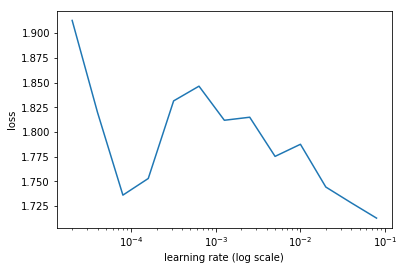

In [18]:
learner.sched.plot(1)

In [19]:
lrf = 1e-2
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

[ 0.       1.20338  1.13304  0.5375 ]                    
[ 1.       0.9588   0.78033  0.7375 ]                     
[ 2.       0.79595  0.72223  0.75   ]                     



Model is unstable:
1. one time underfitting severly in epoch 0: 0.68221 - 1.35695 =~  0.68221
2. then looking good in epoch 1: 1.20165 - 1.29321 =~ 0.09
3. after under fitting: 1.31743 -  1.6248 =~  0.3

## Binary classifications

Here we classify the 4 pathologies an hierarchy of 3 binary classifiers:
1. A classifier all images in 2 classes: Carcinoma and Non Carcinoma
2. A classifier for Carcinoma classified images in 2 classes: InSitu and Invasive
3. A classifier for Non Carcinoma classified images in 2 classes: Normal and Benign

## 5-folds Cross Validations

### Note 
Our dataset has 400 images equally distributed among the 4 classes.
So we use 75 images among each class of the 4 (original) classes for training the Carci binary classifier and 25 for validating/testing our model.
We do the same for the two classifiers: invis and norbe, while ensuring that they are not training on the validation set of the first classifier.

In [9]:
crossvalids = [get_val_idxs(100, 0.2, 1)]
remains = [np.array(list(set(range(100)) - set(crossvalids[-1])))]

In [10]:
crossvalids += [np.random.choice(remains[-1], replace=False, size=20)]
remains += [np.array(list(set(remains[-1]) - set(crossvalids[-1])))]

In [11]:
crossvalids += [np.random.choice(remains[-1], replace=False, size=20)]
remains += [np.array(list(set(remains[-1]) - set(crossvalids[-1])))]

In [13]:
crossvalids += [np.random.choice(remains[-1], replace=False, size=20)]
remains += [np.array(list(set(remains[-1]) - set(crossvalids[-1])))]
crossvalids += [remains[-1]]

In [14]:
for i in range(len(crossvalids)):
    for j in range(i+1,len(crossvalids)):
        print(f'cv[{i}] inter cv[{j}] = {set(crossvalids[i]) & set(crossvalids[j])}')

cv[0] inter cv[1] = set()
cv[0] inter cv[2] = set()
cv[0] inter cv[3] = set()
cv[0] inter cv[4] = set()
cv[1] inter cv[2] = set()
cv[1] inter cv[3] = set()
cv[1] inter cv[4] = set()
cv[2] inter cv[3] = set()
cv[2] inter cv[4] = set()
cv[3] inter cv[4] = set()


In [15]:
crossvalids_np = np.array(crossvalids)

In [16]:
np.save('cv5folds.txt', crossvalids_np, allow_pickle=False )

# 1st split of cross validation

## 1st classifier: Carcinoma and Non Carcinoma

In [8]:
arch=resnet50
bs=10
sz=299
aug = [RandomRotateXY(10), RandomDihedralXY(), RandomFlipXY()]
val_idxs = get_val_idxs(100, 0.25, 4)
data = get_data('train_carci.csv', arch, sz, bs, val_idxs, aug=aug)
learner = ConvLearner.pretrained(arch, data, precompute=False)
learner.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 69267929.27it/s]


In [11]:
lrf = 0.01
lr = np.array([lrf/25., lrf/5., lrf])

A Jupyter Widget

 87%|████████▋ | 26/30 [00:10<00:01,  2.39it/s, loss=8.28] 

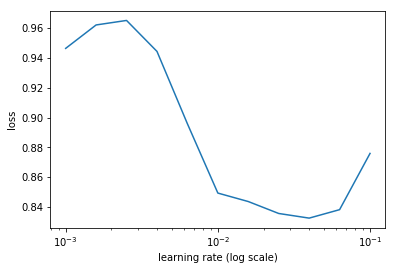

In [28]:
arch=resnet50
bs=10
sz=299
aug = [RandomRotateXY(10), RandomDihedralXY(), RandomFlipXY()]
val_idxs = get_val_idxs(100, 0.25, 4)
data = get_data('train_carci.csv', arch, sz, bs, val_idxs, aug=aug)
learner = ConvLearner.pretrained(arch, data, precompute=False)
learner.lr_find()
learner.sched.plot()

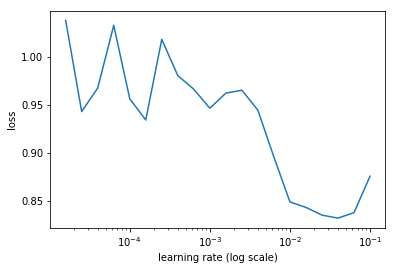

In [29]:
learner.sched.plot(1)

In [30]:
lrf = 0.01
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

  0%|          | 0/30 [00:00<?, ?it/s]                    


Exception in thread Thread-72:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       0.68797  0.37656  0.82   ]                      
[ 1.       0.70761  0.56488  0.72   ]                      
[ 2.       0.91661  0.58805  0.8    ]                      



In [31]:
learner.unfreeze()
lr = np.array([lrf/25., lrf/5., lrf])
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.84078  0.85044  0.66   ]                      
[ 1.       0.75179  0.84042  0.73   ]                      
[ 2.      0.5776  0.8084  0.81  ]                          
[ 3.       0.63441  0.61622  0.82   ]                      
[ 4.       0.58761  0.44036  0.83   ]                      
[ 5.       0.47474  0.50955  0.78   ]                      
[ 6.      0.3982  0.4552  0.8   ]                          



In [11]:
learner.save('bin_carci_89')

In [ ]:
learner.load('bin_carci_89')

In [32]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.3997   0.42867  0.81   ]                      
[ 1.       0.40797  0.36514  0.84   ]                      
[ 2.       0.33643  0.34864  0.85   ]                      
[ 3.       0.28947  0.2725   0.93   ]                      
[ 4.       0.30582  0.36395  0.87   ]                      
[ 5.       0.27149  0.25133  0.92   ]                      
[ 6.       0.23286  0.26159  0.92   ]                      



0.91                                         
0.92
0.91
0.86
0.88
0.88
[[47  3]
 [ 6 44]]


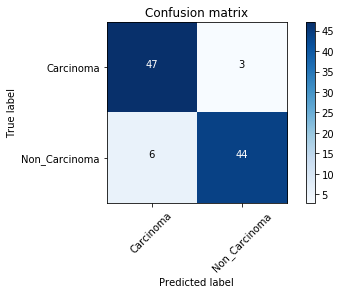

In [33]:
a = evaluate(learner, aug=True)

In [13]:
learner.save('bin_carci_91')

In [ ]:
learner.load("bin_carci_91")

In [34]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.18604  0.30482  0.9    ]                      
[ 1.       0.25044  0.5521   0.82   ]                      
[ 2.       0.19874  0.31176  0.9    ]                      
[ 3.       0.20856  0.34826  0.88   ]                      
[ 4.       0.2264   0.23809  0.88   ]                      
[ 5.       0.19113  0.18657  0.92   ]                      
[ 6.       0.17657  0.17286  0.94   ]                      



0.93                                         
0.94
0.91
0.89
0.86
0.91
[[49  1]
 [ 6 44]]


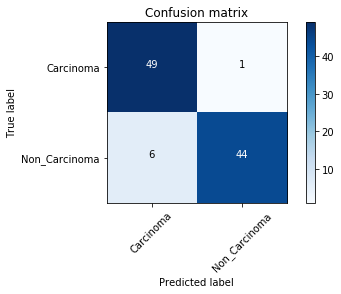

In [35]:
a = evaluate(learner, aug=True)

In [36]:
learner.save('bin_carci_bs10_94')

In [19]:
learner.load('bin_carci_bs10_94')

In [37]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.20536  0.17883  0.95   ]                       
[ 1.       0.30528  0.42061  0.84   ]                      
[ 2.       0.25026  0.38759  0.85   ]                      
[ 3.       0.24511  0.40856  0.94   ]                      
[ 4.       0.2304   0.25907  0.93   ]                      
[ 5.       0.26438  0.2262   0.93   ]                      
[ 6.       0.19216  0.22035  0.95   ]                      



0.94                                         
0.95
0.91
0.91
0.93
0.89
[[49  1]
 [ 5 45]]


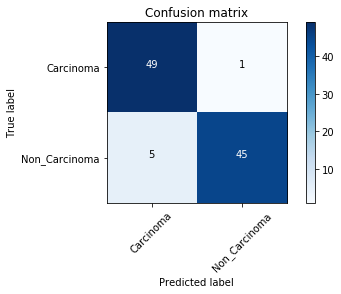

In [38]:
a = evaluate(learner, aug=True)

In [39]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.13918  0.20407  0.96   ]                       
[ 1.       0.2049   0.44702  0.89   ]                      
[ 2.       0.18236  0.35252  0.95   ]                      
[ 3.       0.1415   0.35222  0.91   ]                      
[ 4.       0.17711  0.29219  0.91   ]                      
[ 5.       0.14077  0.39774  0.9    ]                      
[ 6.       0.1252   0.30147  0.93   ]                      



In [105]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.06486  0.18665  0.93   ]                       
[ 1.       0.09633  0.27801  0.93   ]                       
[ 2.       0.13501  0.33354  0.92   ]                      
[ 3.       0.1679   0.40007  0.88   ]                      
[ 4.       0.16886  0.45277  0.87   ]                      
[ 5.       0.13869  0.28576  0.93   ]                      
[ 6.       0.12856  0.26064  0.94   ]                      



In [106]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=3)

A Jupyter Widget

[ 0.       0.07047  0.29104  0.93   ]                       
[ 1.       0.13057  0.48189  0.91   ]                      
[ 2.       0.11124  0.41674  0.91   ]                      
[ 3.       0.12546  0.46509  0.93   ]                       
[ 4.       0.13332  0.66058  0.82   ]                      
[ 5.       0.20845  0.36534  0.85   ]                      
[ 6.       0.17378  0.53365  0.87   ]                      
[ 7.       0.19557  0.21071  0.97   ]                      
[ 8.       0.1895   0.35167  0.9    ]                      
[ 9.       0.12621  0.24659  0.94   ]                      
[ 10.        0.12261   0.16463   0.97   ]                  
[ 11.        0.09661   0.2078    0.96   ]                   
[ 12.        0.08165   0.18453   0.96   ]                   



0.96
[[50  0]
 [ 4 46]]


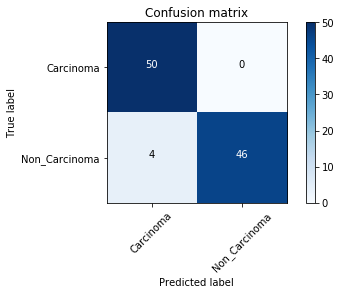

In [108]:
a = evaluate(learner)

In [109]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=3)

A Jupyter Widget

[ 0.       0.07003  0.2927   0.95   ]                       
[ 1.       0.22929  0.56575  0.83   ]                       
[ 2.       0.22198  0.28732  0.92   ]                      
[ 3.       0.14895  0.26071  0.91   ]                      
[ 4.       0.12808  0.30554  0.9    ]                      
[ 5.       0.09498  0.2128   0.95   ]                       
[ 6.       0.11227  0.38491  0.91   ]                       
[ 7.       0.13308  0.30215  0.93   ]                      
[ 8.       0.11823  0.18606  0.95   ]                      
[ 9.       0.15387  0.27112  0.95   ]                      
[ 10.        0.13608   0.22899   0.97   ]                  
[ 11.        0.09373   0.26044   0.96   ]                   
[ 12.        0.08428   0.21318   0.98   ]                   



In [110]:
learner.save('bin_carci_bs10_98')

In [83]:
learner.load('bin_carci_bs10_98')

### RQ: Test time data augmentation is worse for this model

0.95                                         
0.98
0.97
0.94
0.92
0.94
[[49  1]
 [ 4 46]]


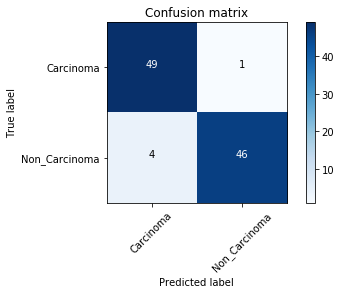

In [115]:
a = evaluate(learner,True)

0.98
[[50  0]
 [ 2 48]]


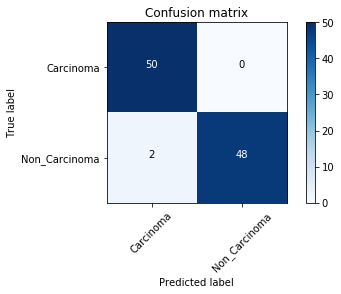

In [112]:
a = evaluate(learner,False)

In [113]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.06508  0.2408   0.93   ]                       
[ 1.       0.08653  0.26826  0.92   ]                       
[ 2.       0.07057  0.25916  0.94   ]                       
[ 3.       0.14441  0.26724  0.94   ]                       
[ 4.       0.10828  0.31879  0.89   ]                      
[ 5.       0.08937  0.22369  0.95   ]                       
[ 6.       0.06403  0.22105  0.94   ]                       



## 2nd Classifier: Normal and Benign 

A Jupyter Widget

[   0.         1.65648  336.11017    0.74   ]              



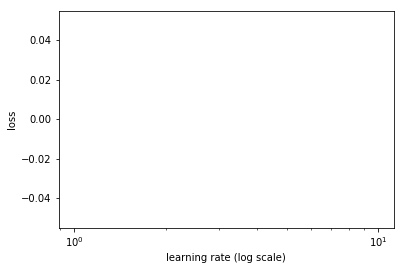

In [151]:
arch=resnet50
bs=10
sz=299
aug = [RandomRotateXY(10), RandomDihedralXY(), RandomFlipXY()]
val_idxs = get_val_idxs(100, 0.25, 2)
data = get_data('train_norbe.csv', arch, sz, bs, val_idxs, aug=aug)
learner = ConvLearner.pretrained(arch, data, precompute=False)
learner.lr_find()
learner.sched.plot()

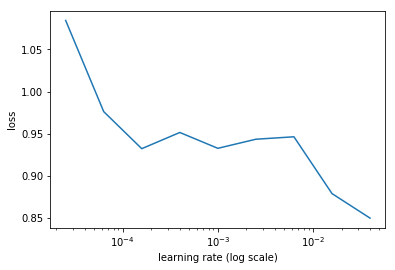

In [152]:
learner.sched.plot(1)

In [153]:
lrf = 0.01
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.70654  0.70834  0.66   ]                      
[ 1.       0.617    0.38087  0.82   ]                      
[ 2.       0.55379  0.31683  0.86   ]                      



In [154]:
learner.unfreeze()
lr = np.array([lrf/25., lrf/5., lrf])
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.83431  0.40319  0.82   ]                      
[ 1.       0.66261  0.29882  0.9    ]                      
[ 2.       0.55721  0.36892  0.82   ]                      
[ 3.       0.50263  0.76633  0.8    ]                      
[ 4.       0.49456  0.36107  0.82   ]                      
[ 5.       0.46868  0.12522  0.94   ]                      
[ 6.       0.41207  0.17533  0.96   ]                      



In [155]:
learner.save('bin_norbe_bs10_96')

In [ ]:
learner.load('bin_norbe_bs10_96')

0.96
[[24  1]
 [ 1 24]]


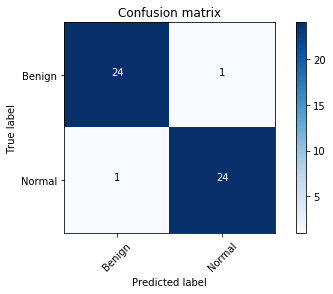

In [159]:
a = evaluate(learner, False)

In [160]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.27589  0.17595  0.94   ]                      
[ 1.       0.31559  0.26401  0.88   ]                      
[ 2.       0.28065  0.22736  0.92   ]                      
[ 3.       0.28009  0.39015  0.9    ]                      
[ 4.       0.28066  0.38442  0.88   ]                      
[ 5.       0.26966  0.08746  0.98   ]                      
[ 6.       0.20735  0.07383  0.98   ]                      



In [161]:
learner.save('bin_norbe_bs10_98')

In [ ]:
learner.load('bin_norbe_bs10_98')

0.98
[[24  1]
 [ 0 25]]


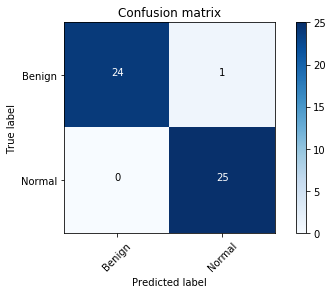

In [163]:
a=evaluate(learner, False)

0.94                                         
0.98
0.94
0.94
0.92
0.96
[[22  3]
 [ 0 25]]


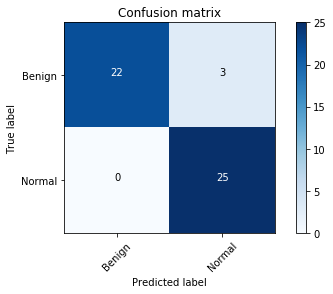

In [164]:
a=evaluate(learner, True)

In [177]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.18629  0.15389  0.94   ]                      
[ 1.       0.14333  0.1892   0.94   ]                      
[ 2.       0.10918  0.08097  0.98   ]                      
[ 3.       0.12893  0.06024  0.96   ]                      
[ 4.       0.17104  0.02842  1.     ]                      
[ 5.       0.2102   0.04487  0.98   ]                      
[ 6.       0.18821  0.04022  1.     ]                      



In [178]:
learner.save('bin_norbe_bs10_100')

In [187]:
learner.load('bin_norbe_bs10_100')

1.0
[[25  0]
 [ 0 25]]


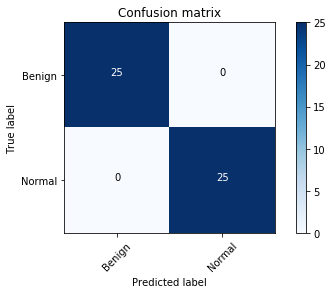

In [188]:
a=evaluate(learner)

## Transfert learning from 1st classifier (Carci) to 2nd classifier (NorBe)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 73%|███████▎  | 11/15 [00:05<00:02,  1.89it/s, loss=1.33]

Exception in thread Thread-211:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 93%|█████████▎| 14/15 [00:06<00:00,  2.15it/s, loss=6.09]


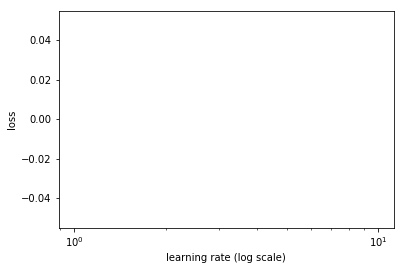

In [84]:
arch=resnet50
bs=10
sz=299
aug = [RandomRotateXY(10), RandomDihedralXY(), RandomFlipXY()]
val_idxs = get_val_idxs(100, 0.25, 2)
data = get_data('train_norbe.csv', arch, sz, bs, val_idxs, aug=aug)
learner.set_data(data)
learner.lr_find()
learner.sched.plot()

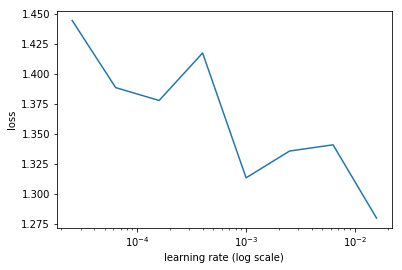

In [85]:
learner.sched.plot(1)

In [86]:
lrf=0.01
learner.data.classes

['Benign', 'Normal']

In [87]:
learner.freeze()
learner.fit(lrf, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.02363  0.47749  0.8    ]                     
[ 1.       0.75984  0.49696  0.84   ]                      
[ 2.       0.60581  0.14223  0.94   ]                      



In [88]:
learner.save('ft_carci_norbe_94_ft')

In [94]:
learner.load('ft_carci_norbe_94_ft')

In [95]:
learner.freeze_to(-2)
learner.fit(lrf, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.44348  0.28297  0.86   ]                      
[ 1.       0.63094  0.57989  0.68   ]                      
[ 2.       0.61828  0.27963  0.88   ]                      



In [96]:
learner.fit(lrf, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.31805  0.35081  0.82   ]                      
[ 1.       0.36829  0.31575  0.9    ]                      
[ 2.       0.32901  0.1474   0.96   ]                      



In [97]:
learner.save('ft_carci_norbe_96_2gps_lay')

In [105]:
learner.load('ft_carci_norbe_96_2gps_lay')

In [104]:
learner.fit(lrf, 4, cycle_len=1, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

[ 0.       0.23945  0.24341  0.92   ]                      
[ 1.       0.36084  0.17211  0.94   ]                      
[ 2.       0.32964  0.18706  0.96   ]                      
[ 3.       0.261    0.19437  0.98   ]                      
[ 4.       0.20572  0.48306  0.92   ]                      
[ 5.       0.2726   0.11151  0.96   ]                      
[ 6.       0.31762  0.52467  0.82   ]                      
[ 7.       0.3693   0.29768  0.84   ]                      
[ 8.       0.34329  0.24335  0.88   ]                      
[ 9.       0.30549  0.36167  0.92   ]                      
[ 10.       0.2616   0.2225   0.94  ]                      
[ 11.        0.24881   0.19146   0.96   ]                  
[ 12.       0.2531   0.1787   0.9   ]                      



## Transfert learning from 1st classifier (Carci) to 3rd classifier (InvIS)

In [26]:
learner.data.classes

['Carcinoma', 'Non_Carcinoma']

In [27]:
arch=resnet50
bs=10
sz=299
aug = [RandomRotateXY(10), RandomDihedralXY(), RandomFlipXY()]
val_idxs = get_val_idxs(100, 0.25, 2)
data = get_data('train_invis.csv', arch, sz, bs, val_idxs, aug=aug)
learner.set_data(data)
learner.data.classes

['InSitu', 'Invasive']

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[    0.          4.97021  5232.36035     0.66   ]         



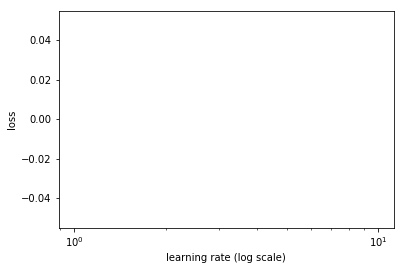

In [28]:
learner.lr_find()
learner.sched.plot()

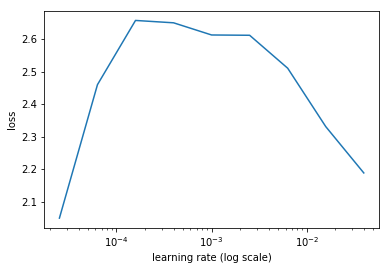

In [29]:
learner.sched.plot(1)

In [39]:
lrf = 0.01
learner.freeze()

In [40]:
learner.fit(lrf, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.37748  0.52105  0.82   ]                     
[ 1.       0.93302  0.53235  0.8    ]                      
[ 2.       0.69548  0.32091  0.88   ]                      



In [41]:
learner.fit(lrf, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.28024  0.27087  0.9    ]                      
[ 1.       0.34372  0.28875  0.9    ]                      
[ 2.       0.29641  0.29979  0.92   ]                      
[ 3.       0.30409  0.39242  0.88   ]                      
[ 4.       0.34943  0.23544  0.92   ]                      
[ 5.       0.33445  0.24213  0.94   ]                      
[ 6.       0.30566  0.22906  0.94   ]                      



In [43]:
learner.fit(lrf, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.17199  0.20803  0.92   ]                      
[ 1.       0.1791   0.22051  0.92   ]                      
[ 2.       0.15241  0.21894  0.92   ]                      
[ 3.       0.17265  0.23896  0.9    ]                      
[ 4.       0.18207  0.23257  0.94   ]                      
[ 5.       0.18688  0.24182  0.94   ]                      
[ 6.       0.20874  0.22003  0.94   ]                      



In [44]:
learner.save('ft_carci_invis_94_ft')

In [54]:
learner.load('ft_carci_invis_94_ft')

In [55]:
learner.freeze_to(-2)

In [56]:
# learner.freeze()
learner.fit(lrf, 3, cycle_len=1, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

[ 0.       0.50624  0.75818  0.82   ]                      
[ 1.       0.56724  1.39562  0.68   ]                      
[ 2.       0.44767  1.40295  0.76   ]                      
[ 3.       0.40323  0.24993  0.9    ]                      
[ 4.       0.40752  0.76192  0.74   ]                      
[ 5.       0.43785  1.31812  0.8    ]                      
[ 6.       0.41768  0.31623  0.92   ]                      
[ 7.       0.3822   0.24153  0.86   ]                      
[ 8.       0.33702  0.15369  0.96   ]                      
[ 9.       0.30923  0.18516  0.94   ]                      
[ 10.        0.25823   0.08635   0.96   ]                  
[ 11.        0.22079   0.11008   0.96   ]                  
[ 12.        0.1929    0.08032   0.98   ]                  



In [57]:
learner.save('ft_carci_invis_2gps_lay_98')

In [76]:
learner.load('ft_carci_invis_2gps_lay_98')

## 3rd Classifier: InSitu and Invasive

A Jupyter Widget

[   0.         2.30464  982.69025    0.52   ]              



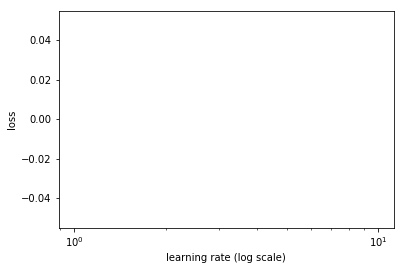

In [133]:
arch=resnet50
bs=10
sz=299
aug = [RandomRotateXY(10), RandomDihedralXY(), RandomFlipXY()]
val_idxs = get_val_idxs(100, 0.25, 2)
data = get_data('train_invis.csv', arch, sz, bs, val_idxs, aug=aug)
learner = ConvLearner.pretrained(arch, data, precompute=False)
learner.lr_find()
learner.sched.plot()

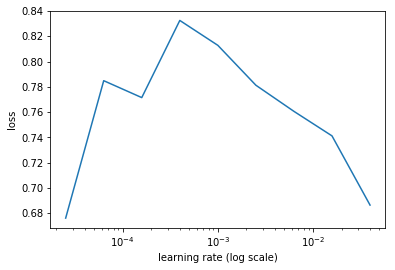

In [134]:
learner.sched.plot(1)

In [135]:
lrf = 0.01
learner.fit(lrf, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.50614  0.65881  0.72   ]                      
[ 1.       0.43104  0.41123  0.82   ]                      
[ 2.       0.39401  0.45609  0.8    ]                      



In [136]:
learner.unfreeze()
lr = np.array([lrf/25., lrf/5., lrf])
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.43731  0.38793  0.86   ]                      
[ 1.       0.46494  0.39948  0.86   ]                      
[ 2.       0.47017  0.34     0.84   ]                      
[ 3.       0.42333  0.36692  0.86   ]                      
[ 4.       0.36079  0.22207  0.94   ]                      
[ 5.       0.33635  0.19706  0.9    ]                      
[ 6.       0.30365  0.1858   0.92   ]                      



In [137]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.18176  0.17053  0.92   ]                       
[ 1.       0.22305  0.23705  0.88   ]                      
[ 2.       0.18691  0.18036  0.9    ]                      
[ 3.       0.17098  0.5238   0.82   ]                      
[ 4.       0.18991  0.11409  0.98   ]                      
[ 5.       0.15426  0.11767  0.94   ]                      
[ 6.       0.13503  0.11043  0.96   ]                      



0.96
[[24  1]
 [ 1 24]]


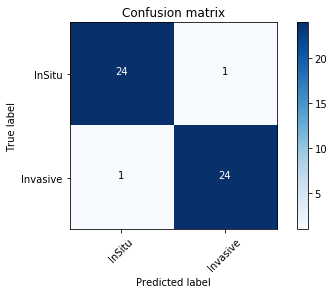

In [141]:
a=evaluate(learner, False)

In [138]:
learner.save('bin_invis_bs10_96')

In [ ]:
learner.load('bin_invis_bs10_96')

In [142]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.11125  0.13067  0.94   ]                      
[ 1.       0.12087  0.30597  0.9    ]                      
[ 2.       0.13854  0.10583  0.94   ]                      
[ 3.       0.1405   0.25267  0.92   ]                      
[ 4.       0.14006  0.13571  0.96   ]                      
[ 5.       0.16679  0.07219  0.96   ]                      
[ 6.       0.17612  0.05871  0.96   ]                      



0.96                                         
0.96
0.92
0.98
0.96
0.96
[[23  2]
 [ 0 25]]


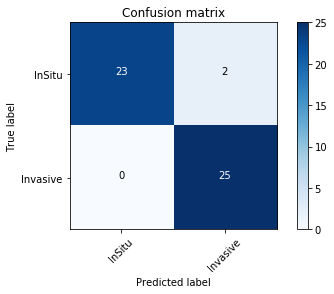

In [146]:
a=evaluate(learner,True)

[[24  1]
 [ 0 25]]


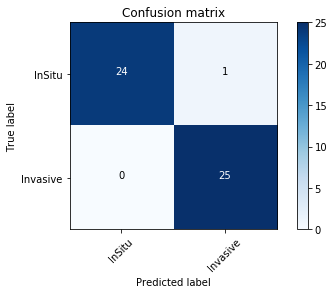

In [148]:
plot_cm(learner.data.classes, a[1], np.argmax(a[0][2],axis=1))

In [143]:
learner.save('bin_invis_bs10_96_bis')

In [20]:
learner.load('bin_invis_bs10_96_bis')

In [23]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.21206  0.31355  0.89   ]                      
[ 1.       0.19809  0.65704  0.85   ]                      
[ 2.      0.1585  0.3943  0.89  ]                          
[ 3.       0.21602  0.24531  0.91   ]                      
[ 4.       0.22908  0.2474   0.91   ]                      
[ 5.       0.31683  0.26967  0.87   ]                      
[ 6.       0.26403  0.21601  0.92   ]                      



In [24]:
learner.data.classes

['Carcinoma', 'Non_Carcinoma']

In [149]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.02189  0.08485  0.96   ]                       
[ 1.       0.0884   0.11992  0.94   ]                       
[ 2.       0.16418  0.14812  0.94   ]                      
[ 3.       0.13122  0.33138  0.92   ]                      
[ 4.       0.13274  0.20861  0.92   ]                      
[ 5.       0.15856  0.11884  0.94   ]                      
[ 6.       0.13324  0.12287  0.94   ]                      



In [150]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=3)

A Jupyter Widget

[ 0.       0.06904  0.09435  0.96   ]                       
[ 1.       0.07295  0.06979  0.98   ]                       
[ 2.       0.13988  0.13203  0.94   ]                      
[ 3.       0.14742  0.09967  0.96   ]                      
[ 4.       0.12056  0.31314  0.9    ]                      
[ 5.       0.12185  0.11979  0.94   ]                      
[ 6.       0.15047  0.14486  0.92   ]                      
[ 7.       0.1506   0.17913  0.94   ]                      
[ 8.       0.18868  0.10784  0.96   ]                      
[ 9.       0.16653  0.12301  0.96   ]                      
[ 10.        0.15404   0.11053   0.96   ]                  
[ 11.        0.14728   0.09348   0.94   ]                  
[ 12.        0.12615   0.10869   0.96   ]                  



## Qualitative Analysis of model result on data

In [165]:
log_probs, y = learner.predict_with_targs()
# pr = Prob(image_class == 'Non_Carcinoma')
# if pr < 0.5 => image_class = Carcinoma
# else: image_class = Non_Carcinoma
probs = np.exp(log_probs[:,1]) 
preds = np.argmax(log_probs, axis=1)
learner.data.classes

['Benign', 'Normal']

In [94]:
def rand_by_mask(mask, n=4):
    m = np.where(mask)[0]
    print(f'nb images :{len(m)}')
    return np.random.choice(m, n, replace=False)
def rand_by_correct(is_correct, n=4): return rand_by_mask((preds == data.val_y)==is_correct, n)

In [95]:
def plot_val_with_title(idxs, title, rows=1):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=rows, titles=title_probs)

In [96]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [97]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title, rows=1):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(probs[x], data.val_ds.fnames[x]) for x in idxs]
    print(title)
    return plots(imgs, rows=rows, titles=title_probs, figsize=(16,8))

nb images :49
Correctly classified


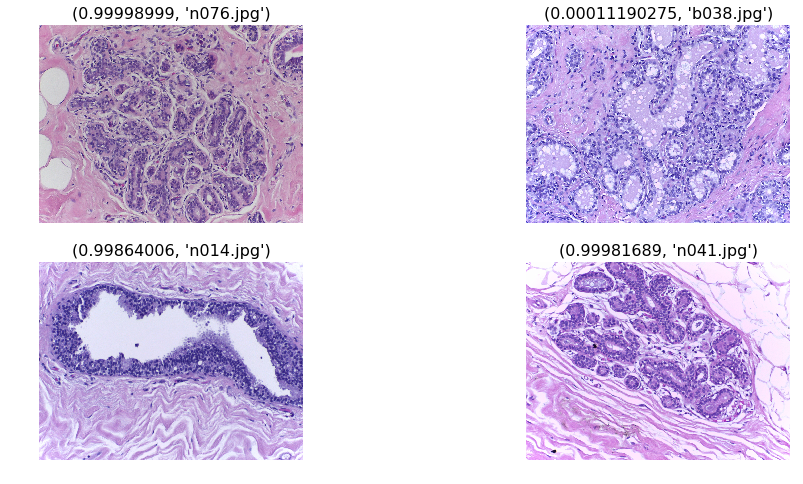

In [166]:
# 1. A few correct labels at random

plot_val_with_title(rand_by_correct(True), "Correctly classified", rows=2)

nb images :1
InCorrectly classified


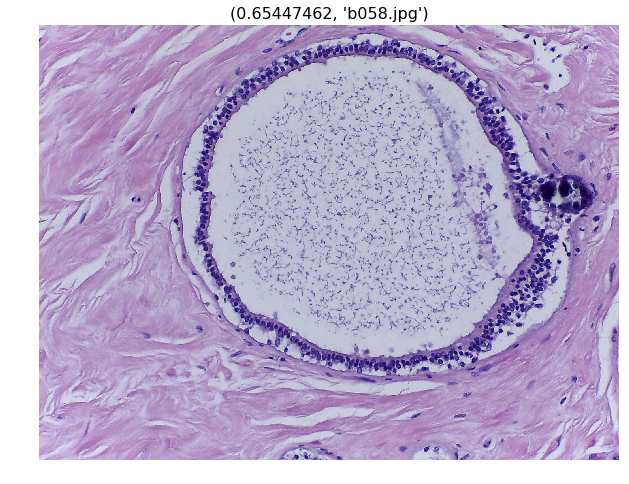

In [169]:
plot_val_with_title(rand_by_correct(False, 1), "InCorrectly classified", rows=1)

nb images :24
Most correct Benign


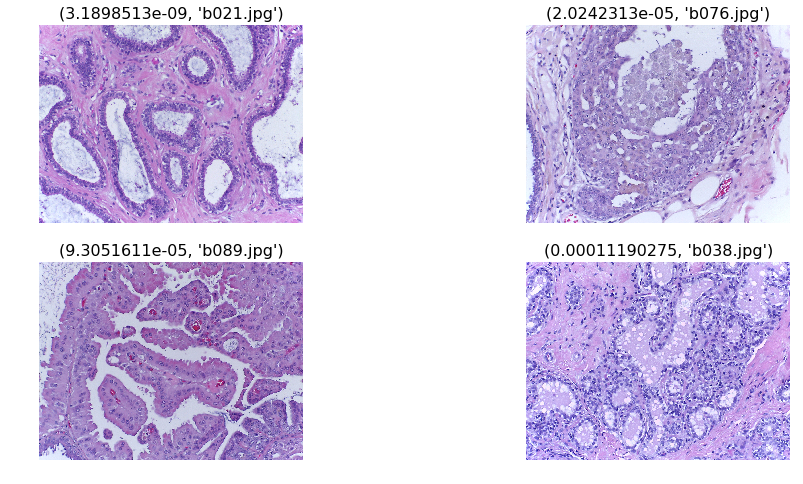

In [171]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    print(f'nb images :{len(idxs)}')
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)
plot_val_with_title(most_by_correct(0, True), "Most correct Benign",rows=2)

nb images :1
Most INCORRECTS Benign


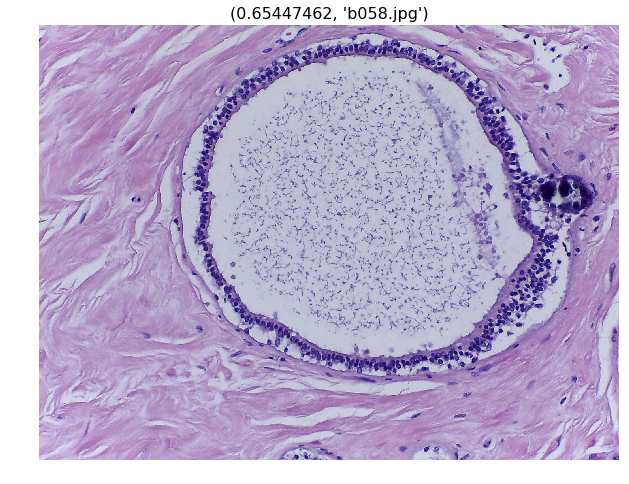

In [173]:
plot_val_with_title(most_by_correct(0, False), "Most INCORRECTS Benign",rows=1)

nb images :26
Most correct Normal


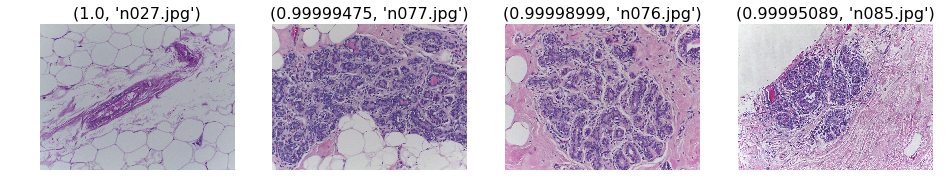

In [174]:
plot_val_with_title(most_by_correct(1, True), "Most correct Normal", rows=1)

nb images :1
Most INCORRECT Normal


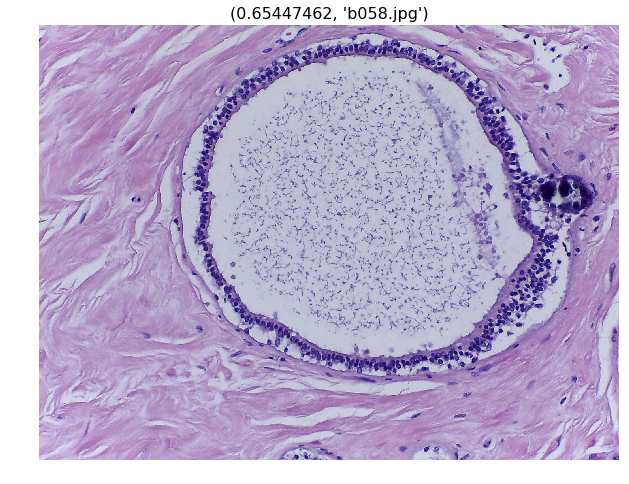

In [175]:
plot_val_with_title(most_by_correct(1, False), "Most INCORRECT Normal")

Most uncertain predictions


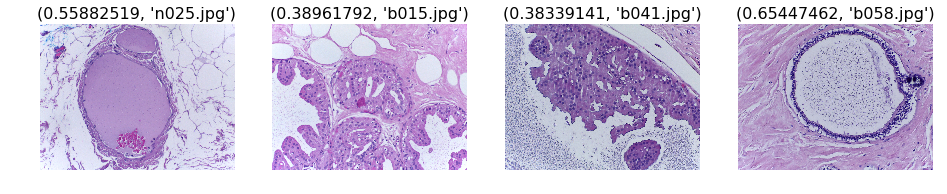

In [176]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")